In [ ]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#Import Dataset from Drive
from google.colab import drive
drive.mount('/content/drive')
data= '/content/drive/MyDrive/ml_engineer/p2_Smart_Clustering_Engine/rfm_customers.csv'
#Define Data frame
df= pd.read_csv(data)
#Show Data frame
#df.head()
#Data frame to Sql
import sqlite3
#Create SQLite in-memory DataBase
conn=sqlite3.connect(':memory:')
df.to_sql('customers',conn,index=False, if_exists='replace')
# Test query
query = "SELECT * FROM customers LIMIT 5;"
sql_result = pd.read_sql(query, conn)
sql_result
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#Import Dataset from Drive
from google.colab import drive
drive.mount('/content/drive')
data= '/content/drive/MyDrive/ml_engineer/p2_Smart_Clustering_Engine/rfm_customers.csv'
#Define Data frame
df= pd.read_csv(data)
#Show Data frame
#df.head()
#Data frame to Sql
import sqlite3
#Create SQLite in-memory DataBase
conn=sqlite3.connect(':memory:')
df.to_sql('customers',conn,index=False, if_exists='replace')
# Test query
query = "SELECT * FROM customers LIMIT 5;"
sql_result = pd.read_sql(query, conn)
sql_result
# Exploratory Data Analysis (EDA): Understanding data distribution, patterns, and potential anomalies
# Calculating the total number of unique customers in the dataset
query = "SELECT COUNT(*) AS Total_Customers FROM customers;"
sql_result = pd.read_sql(query,conn)
print(sql_result)
# Generating descriptive statistics to understand central tendency and dispersion
query ="""SELECT
  ROUND(AVG(Recency), 1) AS Avg_Recency,
  MIN(Recency) AS Min_Recency,
  MAX(Recency) AS Max_Recency,

  ROUND(AVG(Frequency), 1) AS Avg_Frequency,
  MIN(Frequency) AS Min_Frequency,
  MAX(Frequency) AS Max_Frequency,

  ROUND(AVG(MonetaryValue), 0) AS Avg_Monetary,
  MIN(MonetaryValue) AS Min_Monetary,
  MAX(MonetaryValue) AS Max_Monetary

FROM customers;"""
sql_result = pd.read_sql(query,conn)
print(sql_result)
#One time buyers
query="""SELECT COUNT(*) AS One_Time_Buyers
FROM customers
WHERE Frequency = 1;"""
sql_result = pd.read_sql(query,conn)
print(sql_result)
#Big spenders
query="""SELECT COUNT(*) AS Big_Spenders
FROM customers
WHERE MonetaryValue > 800000;"""
sql_result = pd.read_sql(query,conn)
print(sql_result)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
   Total_Customers
0              200
   Avg_Recency  Min_Recency  Max_Recency  Avg_Frequency  Min_Frequency  \
0         49.4            1           99            9.5              1   

   Max_Frequency  Avg_Monetary  Min_Monetary  Max_Monetary  
0             19      490926.0         13267        999873  
   One_Time_Buyers
0               20
   Big_Spenders
0            36


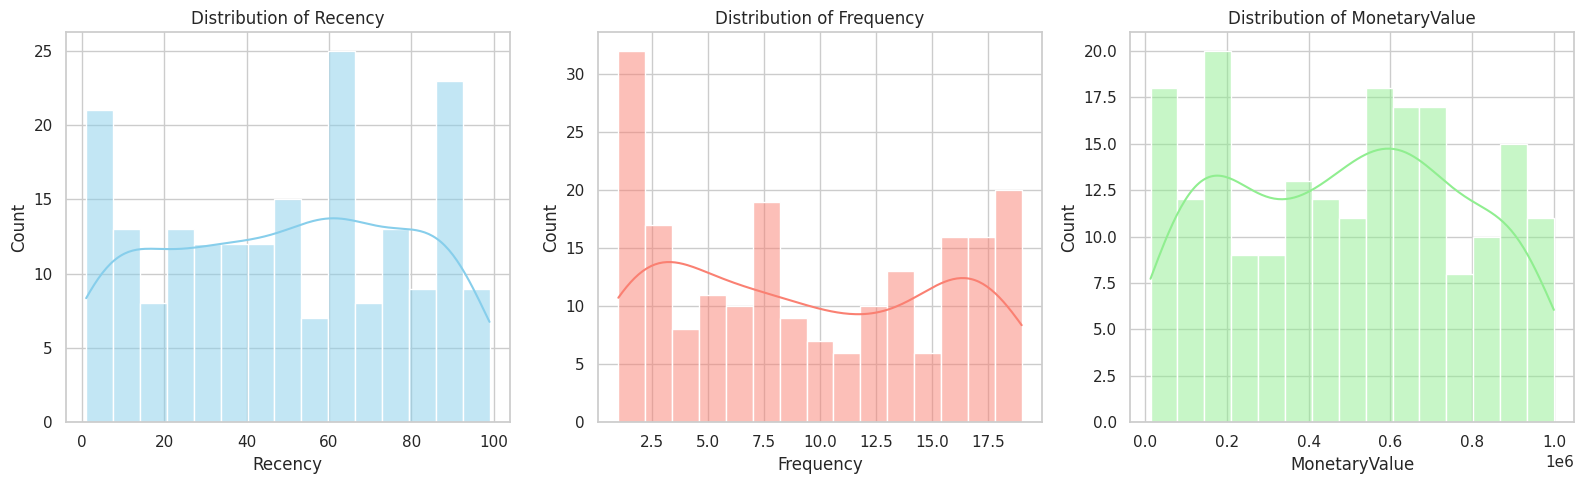

In [ ]:
# Visual Exploratory Data Analysis: identifying patterns, trends, and outliers through plots
# Setting visualization style for consistent and readable plots
sns.set(style="whitegrid")
plt.figure(figsize=(16,5))
# Histogram to visualize the distribution of Recency values
# Helps identify customer engagement levels based on how recently they made a purchase
plt.subplot(1, 3, 1)
sns.histplot(df['Recency'], kde=True, bins=15, color='skyblue')
plt.title('Distribution of Recency')
# Histogram to visualize the distribution of Frequency values
# Shows how often customers make purchases, helping identify loyal customers
plt.subplot(1, 3, 2)
sns.histplot(df['Frequency'], kde=True, bins=15, color='salmon')
plt.title('Distribution of Frequency')
# Histogram to visualize the distribution of Monetary Value
# Reveals how much customers spend, helping identify high-value segments
plt.subplot(1, 3, 3)
sns.histplot(df['MonetaryValue'], kde=True, bins=15, color='lightgreen')
plt.title('Distribution of MonetaryValue')

plt.tight_layout()
plt.show()

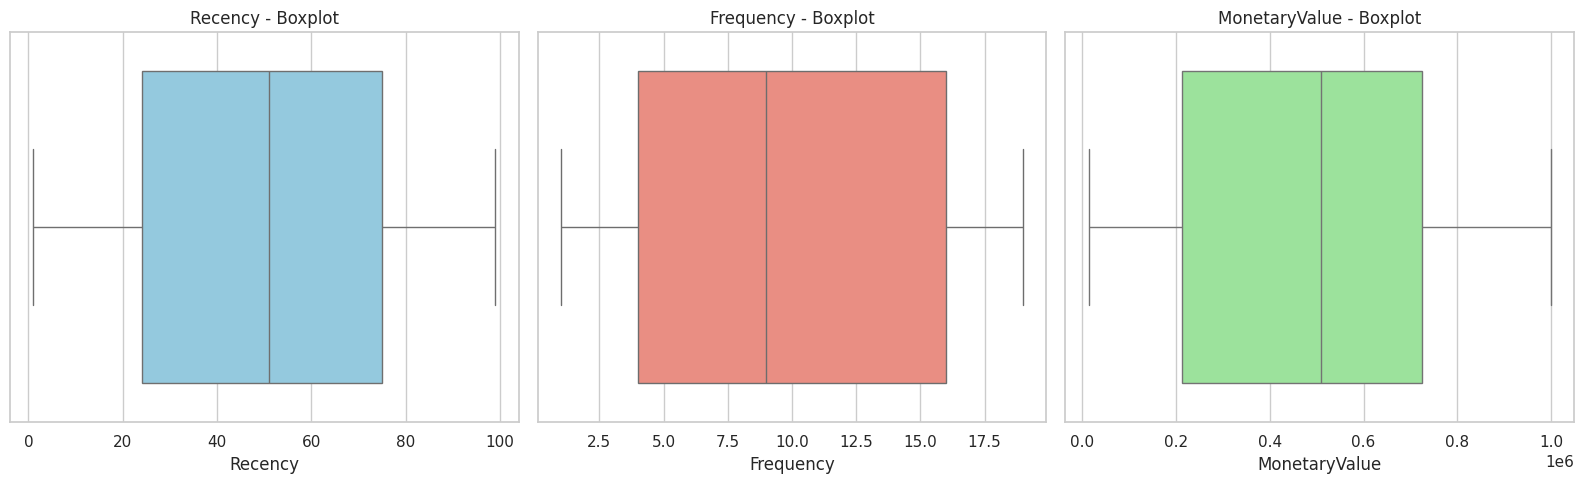

In [ ]:
#Box plots
plt.figure(figsize=(16,5))

# Boxplot de Recency
plt.subplot(1, 3, 1)
sns.boxplot(x=df['Recency'], color='skyblue')
plt.title('Recency - Boxplot')

# Boxplot de Frequency
plt.subplot(1, 3, 2)
sns.boxplot(x=df['Frequency'], color='salmon')
plt.title('Frequency - Boxplot')

# Boxplot de MonetaryValue
plt.subplot(1, 3, 3)
sns.boxplot(x=df['MonetaryValue'], color='lightgreen')
plt.title('MonetaryValue - Boxplot')

plt.tight_layout()
plt.show()


In [ ]:
# Scaling numerical features to normalize value ranges and prepare data for modeling
# Useful when features have different units or magnitudes
from sklearn.preprocessing import StandardScaler

# Seleccionar solo las columnas numéricas que queremos escalar
rfm_features = df[['Recency', 'Frequency', 'MonetaryValue']]

# Crear el objeto scaler
scaler = StandardScaler()

# Ajustar el scaler a los datos y transformarlos
rfm_scaled = scaler.fit_transform(rfm_features)

# Convertirlo a DataFrame nuevamente para visualizar
rfm_scaled_df = pd.DataFrame(rfm_scaled, columns=['Recency', 'Frequency', 'MonetaryValue'])

# Mostrar las primeras filas escaladas
rfm_scaled_df.head()


,Recency,Frequency,MonetaryValue
0,0.08988,-0.740562,1.527874
1,1.48839,-1.406235,-1.063440
2,-1.17219,1.589296,0.638175
3,0.77208,0.091530,0.170187
4,0.39687,0.424367,-1.613900


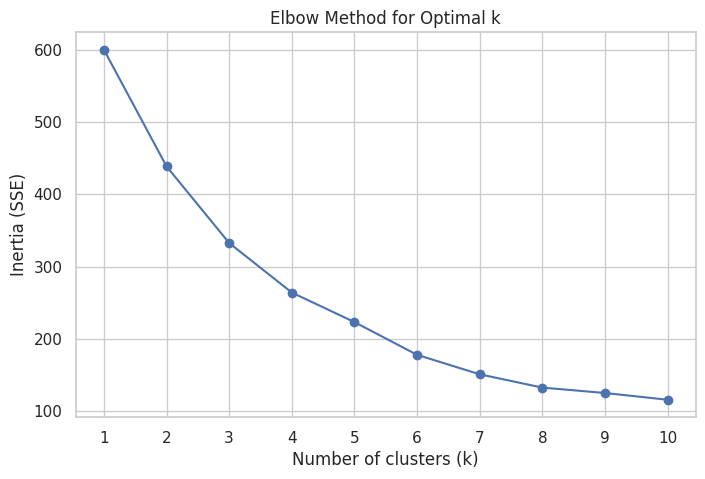

In [ ]:
# Applying the Elbow Method to determine the optimal number of clusters for K-Means
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []
K = range(1, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled_df)
    inertia.append(kmeans.inertia_)

# Graficar el método del codo
plt.figure(figsize=(8, 5))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (SSE)')
plt.title('Elbow Method for Optimal k')
plt.xticks(K)
plt.grid(True)
plt.show()


In [ ]:
# Evaluating each k value to identify the most meaningful and stable customer segments
from sklearn.cluster import KMeans

# Crear modelo con k=10 clusters
# Creating K-Means clustering model with k=10 to segment customers into 10 distinct groups
kmeans_10 = KMeans(n_clusters=10, random_state=42)
kmeans_10.fit(rfm_scaled_df)

# Obtener las etiquetas asignadas
# Retrieving cluster labels assigned to each data point by the K-Means model
clusters_10 = kmeans_10.labels_

# Crear una copia del DataFrame original para análisis
# Creating a copy of the original DataFrame for cluster-based analysis without altering the raw data
df_10 = df.copy()
df_10['Cluster'] = clusters_10

# Ver el tamaño de cada grupo
#Checking the size of each cluster to evaluate group distribution

cluster_sizes = df_10['Cluster'].value_counts().sort_index()
print("Tamaño por cluster (k=10):")
print(cluster_sizes)

# Ver los promedios de RFM por grupo
#Calculating average Recency, Frequency, and Monetary Value for each cluster to profile customer segments
rfm_summary = df_10.groupby('Cluster')[['Recency', 'Frequency', 'MonetaryValue']].mean().round(1)
print("\nPromedios por cluster (k=10):")
print(rfm_summary)


Tamaño por cluster (k=10):
Cluster
0    24
1    14
2    22
3    24
4    15
5    17
6    21
7    21
8    20
9    22
Name: count, dtype: int64

Promedios por cluster (k=10):
         Recency  Frequency  MonetaryValue
Cluster                                   
0           12.5        4.1       753596.5
1           78.9        9.4       252611.1
2           54.2        4.5       507550.2
3           20.9       15.6       718529.3
4           22.3       16.5       144662.3
5           76.6        2.5       171960.0
6           80.0       15.5       732382.0
7           74.3        4.5       799130.4
8           24.8        6.4       316926.4
9           63.7       15.6       207180.0


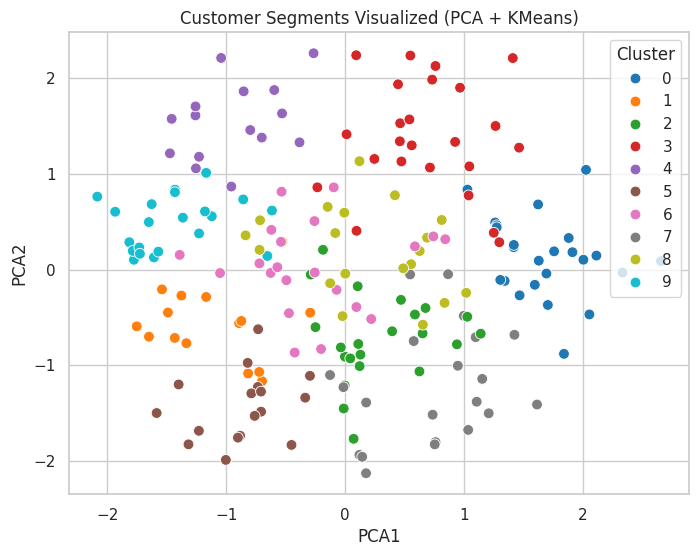

In [ ]:
# Reducing dimensionality to 2D using PCA for visualizing K-Means clustering results
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reducir dimensiones con PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(rfm_scaled_df)

# Agregar clusters al dataset visual
df_viz = pd.DataFrame(pca_data, columns=['PCA1', 'PCA2'])
df_viz['Cluster'] = df_10['Cluster']

# Graficar los clusters
plt.figure(figsize=(8,6))
sns.scatterplot(data=df_viz, x='PCA1', y='PCA2', hue='Cluster', palette='tab10', s=60)
plt.title('Customer Segments Visualized (PCA + KMeans)')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()


In [ ]:
# Assigning each customer to a cluster based on K-Means results
df_10.to_csv('customer_segments_k10.csv', index=False)
df = pd.read_csv('customer_segments_k10.csv')
df.head()


,CustomerID,Recency,Frequency,MonetaryValue,Cluster
0,1,52,5,927230,7
1,2,93,1,187247,5
2,3,15,19,673165,3
3,4,72,10,539525,1
4,5,61,12,30056,9


# 🧠 Smart Clustering Engine — Customer Segmentation Report

## 📋 Objective

To segment e-commerce customers based on behavioral data using SQL, applied statistics, and unsupervised Machine Learning (K-Means). The goal is to enable the business to understand different customer types and design targeted strategies.

---

## 📁 Dataset Summary

- **Recency**: Days since the customer's last purchase
- **Frequency**: Number of purchases in a defined period
- **MonetaryValue**: Total spending by the customer
- **Records analyzed**: 200 customers

---

## 🛠️ Analytical Process

1. **Data Loading and SQL Exploration**  
   - Used `sqlite3` to run SQL queries for initial data profiling  
   - Extracted average, min, max, and outlier detection with SQL commands

2. **Statistical Analysis with pandas + seaborn**  
   - Histograms and boxplots revealed non-normal distributions  
   - Detected asymmetry and high dispersion in `MonetaryValue`  
   - Confirmed the need for feature scaling

3. **Preprocessing**  
   - Scaled `Recency`, `Frequency`, `MonetaryValue` using `StandardScaler`

4. **K-Means Clustering**  
   - Optimal number of clusters identified with Elbow Method  
   - Applied KMeans with `k=10`, resulting in well-distributed segments

5. **Visualization**  
   - Boxplots and cluster scatterplots via PCA  
   - Each cluster showed unique behavioral patterns

---

## 📈 Key Visuals

- **Histograms of RFM variables**: Showed distributions and skew
- **Boxplots**: Highlighted outliers and asymmetry
- **Elbow Method**: Helped determine optimal `k`
- **PCA Scatter Plot**: Visual confirmation of distinct clusters

All plots are included inline above this section in the notebook.

---

## 🧠 Cluster Insights (examples)

| Cluster | Description |
|---------|-------------|
| 0 | High-value clients with recent purchases and moderate frequency |
| 3 | Very frequent buyers with high spend and recent recency |
| 5 | Low frequency, low value, long time since last purchase |
| 7 | High spenders with low frequency and high recency (VIPs at risk) |

---

## 📦 Output

- 📄 `customer_segments_k10.csv`: final dataset with cluster labels
- 📘 This notebook: contains full analysis, visualizations and code

---

## 🧩 Conclusion

K-Means clustering helped uncover 10 distinct customer profiles based on purchasing behavior. These segments provide a foundation for personalized marketing, churn prevention, and lifetime value strategies. The approach is reproducible and adaptable for real-world e-commerce scenarios.

